In [1]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt

def obtain_lightcurve(source, author='K2'):
    search_result_q4 = lk.search_lightcurve(source, author=author)
    lc = search_result_q4.download()
    lc = lc.remove_outliers(sigma=5)
    lc.plot()
    return lc

lc16 = obtain_lightcurve('16 Tau', author='K2')

f = open('lc16.csv', 'w')
for i in range(len(lc16)):
    out_str = f'{i},{lc16['time'][i]},{lc16['flux'][i].value}\n'
    f.write(out_str)
    #print(out_str)
f.close()



ModuleNotFoundError: No module named 'lightkurve'

=== Processing Pleiades Star Light Curves ===

Processing Asterope

Reading Asterope-lightkurve-ts.csv:
  Shape: (3231, 3)
  Columns: ['0', '2229.106673735274', '57234116.0']
  Data points: 3231
  Time range: 2229.127106 to 2299.677940
  Flux range: 57235044 to 57319980

Processing Asterope:
  Removed 67 points from initial 1.5 day drift period
  Remaining data points: 3164
  Final time span: 69.0 days
  Mean normalized flux: 1.000000
  Flux std deviation: 0.000145
  Flux range: 0.999470 to 1.000716
  Saved to: ./data/asterope_processed.csv

Processing Celaeno

Reading celeano-lightkurve-ts.csv:
  Shape: (3215, 3)
  Columns: ['0', '2229.2088177922487', '75757472.0']
  Data points: 3215
  Time range: 2229.229250 to 2299.677910
  Flux range: 75758736 to 75880520

Processing Celaeno:
  Removed 69 points from initial 1.5 day drift period
  Remaining data points: 3146
  Final time span: 68.9 days
  Mean normalized flux: 1.000000
  Flux std deviation: 0.000159
  Flux range: 0.999492 to 1.000

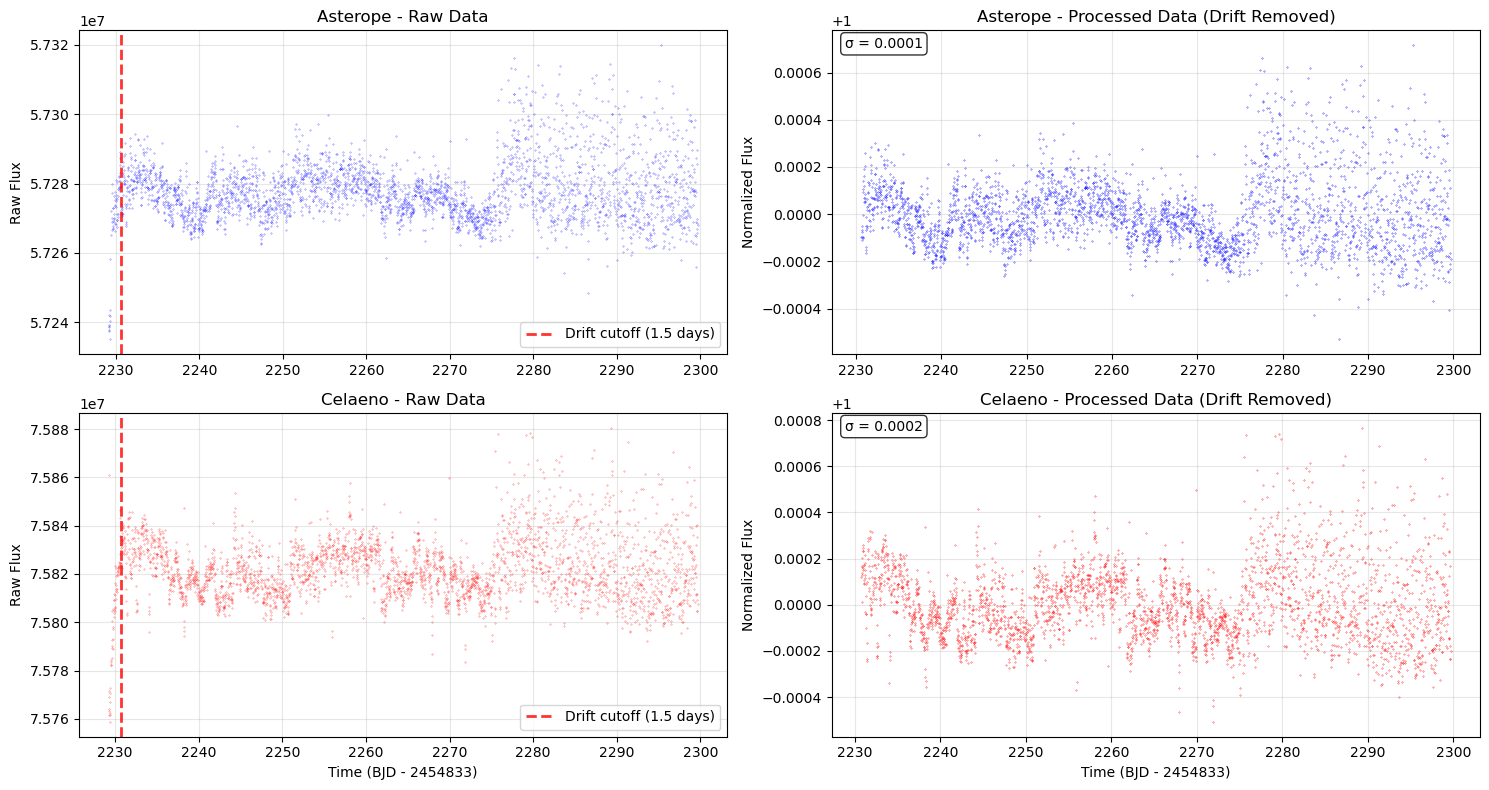


PROCESSING SUMMARY

Asterope:
  Original data points: 3,231
  Removed (drift): 67
  Final data points: 3,164
  Data removal: 2.1%
  Time span: 69.0 days
  Flux variability (σ): 0.0001

Celaeno:
  Original data points: 3,215
  Removed (drift): 69
  Final data points: 3,146
  Data removal: 2.1%
  Time span: 68.9 days
  Flux variability (σ): 0.0002

Creating direct comparison plot...


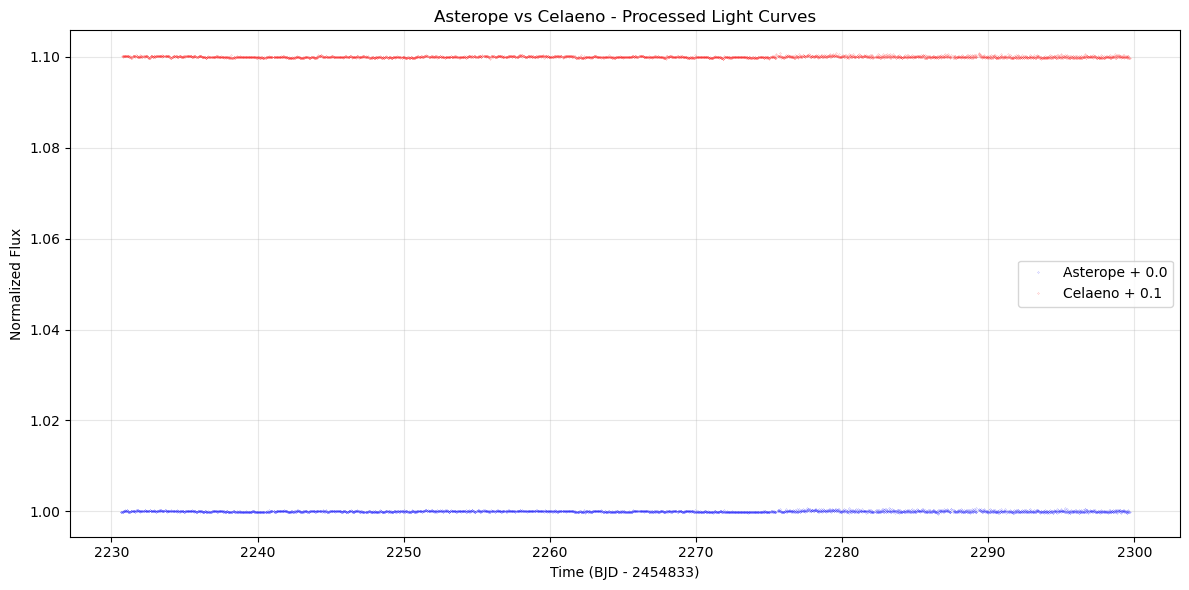

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def read_lightcurve_data(filepath):
    """Read light curve data from CSV file"""
    try:
        # Read the CSV file
        df = pd.read_csv(filepath)
        
        # Print file info
        print(f"\nReading {os.path.basename(filepath)}:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {df.columns.tolist()}")
        
        # Extract time and flux columns (assuming columns 1 and 2 are time and flux)
        if len(df.columns) >= 3:
            times = df.iloc[:, 1].values  # Second column (B in Excel)
            fluxes = df.iloc[:, 2].values  # Third column (C in Excel)
        else:
            times = df.iloc[:, 0].values
            fluxes = df.iloc[:, 1].values
        
        print(f"  Data points: {len(times)}")
        print(f"  Time range: {times[0]:.6f} to {times[-1]:.6f}")
        print(f"  Flux range: {fluxes.min():.0f} to {fluxes.max():.0f}")
        
        return times, fluxes
        
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None, None

def process_light_curve(times, fluxes, star_name, drift_days=1.5):
    """
    Process light curve data by removing initial drift and normalizing
    """
    print(f"\nProcessing {star_name}:")
    
    # Remove initial drift period
    start_time = times[0]
    cutoff_time = start_time + drift_days
    good_indices = times > cutoff_time
    
    clean_times = times[good_indices]
    clean_fluxes = fluxes[good_indices]
    
    removed_points = np.sum(~good_indices)
    print(f"  Removed {removed_points} points from initial {drift_days} day drift period")
    print(f"  Remaining data points: {len(clean_times)}")
    
    # Normalize to median and convert to relative flux
    median_flux = np.median(clean_fluxes)
    normalized_fluxes = clean_fluxes / median_flux
    
    # Remove linear trend
    coeffs = np.polyfit(clean_times - clean_times[0], normalized_fluxes, 1)
    linear_trend = np.polyval(coeffs, clean_times - clean_times[0])
    detrended_fluxes = normalized_fluxes - linear_trend + 1.0
    
    # Print final statistics
    print(f"  Final time span: {clean_times[-1] - clean_times[0]:.1f} days")
    print(f"  Mean normalized flux: {np.mean(detrended_fluxes):.6f}")
    print(f"  Flux std deviation: {np.std(detrended_fluxes):.6f}")
    print(f"  Flux range: {np.min(detrended_fluxes):.6f} to {np.max(detrended_fluxes):.6f}")
    
    return clean_times, detrended_fluxes, removed_points

def save_processed_data(times, fluxes, star_name, output_dir='./data/'):
    """Save processed light curve to file"""
    filename = f"{output_dir}{star_name.lower()}_processed.csv"
    output_df = pd.DataFrame({
        'Time_BJD_minus_2454833': times,
        'Normalized_Flux': fluxes
    })
    output_df.to_csv(filename, index=False)
    print(f"  Saved to: {filename}")
    return filename

# Main processing loop
def process_pleiades_stars():
    """Process both Asterope and Celaeno light curve data"""
    
    # Define the files to process
    star_files = {
        'Asterope': './data/Asterope-lightkurve-ts.csv',
        'Celaeno': './data/celeano-lightkurve-ts.csv'  # Adjust filename if different
    }
    
    processed_data = {}
    processing_stats = {}
    
    print("=== Processing Pleiades Star Light Curves ===")
    
    # Loop through each star file
    for star_name, filepath in star_files.items():
        print(f"\n{'='*50}")
        print(f"Processing {star_name}")
        print(f"{'='*50}")
        
        # Check if file exists
        if not os.path.exists(filepath):
            print(f"Warning: File not found: {filepath}")
            continue
        
        # Read the data
        times, fluxes = read_lightcurve_data(filepath)
        
        if times is not None:
            # Process the data
            clean_times, processed_fluxes, removed_points = process_light_curve(
                times, fluxes, star_name, drift_days=1.5
            )
            
            # Save processed data
            output_file = save_processed_data(clean_times, processed_fluxes, star_name)
            
            # Store results
            processed_data[star_name] = {
                'times': clean_times,
                'fluxes': processed_fluxes,
                'raw_times': times,
                'raw_fluxes': fluxes
            }
            
            processing_stats[star_name] = {
                'original_points': len(times),
                'removed_points': removed_points,
                'final_points': len(clean_times),
                'time_span': clean_times[-1] - clean_times[0],
                'flux_std': np.std(processed_fluxes)
            }
        else:
            print(f"Failed to process {star_name}")
    
    return processed_data, processing_stats

# Run the processing
processed_data, stats = process_pleiades_stars()

# Create comprehensive plots
if len(processed_data) > 0:
    print(f"\n{'='*50}")
    print("Creating comparison plots...")
    
    n_stars = len(processed_data)
    fig, axes = plt.subplots(n_stars, 2, figsize=(15, 4*n_stars))
    
    if n_stars == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['blue', 'red', 'green', 'purple']
    
    for i, (star_name, data) in enumerate(processed_data.items()):
        color = colors[i % len(colors)]
        
        # Raw data with drift period highlighted
        axes[i, 0].plot(data['raw_times'], data['raw_fluxes'], '.', 
                       color=color, markersize=0.5, alpha=0.7)
        
        # Mark the drift cutoff
        cutoff_time = data['raw_times'][0] + 1.5
        axes[i, 0].axvline(cutoff_time, color='red', linestyle='--', 
                          alpha=0.8, linewidth=2, label='Drift cutoff (1.5 days)')
        
        axes[i, 0].set_title(f'{star_name} - Raw Data')
        axes[i, 0].set_ylabel('Raw Flux')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Processed data
        axes[i, 1].plot(data['times'], data['fluxes'], '.', 
                       color=color, markersize=0.5)
        axes[i, 1].set_title(f'{star_name} - Processed Data (Drift Removed)')
        axes[i, 1].set_ylabel('Normalized Flux')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Add statistics as text
        std_dev = np.std(data['fluxes'])
        axes[i, 1].text(0.02, 0.98, f'σ = {std_dev:.4f}', 
                       transform=axes[i, 1].transAxes, 
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Set x-labels for bottom plots
    for j in range(2):
        axes[-1, j].set_xlabel('Time (BJD - 2454833)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*50}")
    print("PROCESSING SUMMARY")
    print(f"{'='*50}")
    
    for star_name, stat in stats.items():
        print(f"\n{star_name}:")
        print(f"  Original data points: {stat['original_points']:,}")
        print(f"  Removed (drift): {stat['removed_points']:,}")
        print(f"  Final data points: {stat['final_points']:,}")
        print(f"  Data removal: {stat['removed_points']/stat['original_points']*100:.1f}%")
        print(f"  Time span: {stat['time_span']:.1f} days")
        print(f"  Flux variability (σ): {stat['flux_std']:.4f}")
    
    # Create a side-by-side comparison if we have both stars
    if len(processed_data) == 2:
        print(f"\nCreating direct comparison plot...")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        star_names = list(processed_data.keys())
        colors = ['blue', 'red']
        
        for i, star_name in enumerate(star_names):
            data = processed_data[star_name]
            # Offset fluxes for better visualization
            offset = i * 0.1
            ax.plot(data['times'], data['fluxes'] + offset, '.', 
                   color=colors[i], markersize=0.3, alpha=0.7, label=f'{star_name} + {offset:.1f}')
        
        ax.set_xlabel('Time (BJD - 2454833)')
        ax.set_ylabel('Normalized Flux')
        ax.set_title('Asterope vs Celaeno - Processed Light Curves')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

else:
    print("No data was successfully processed. Please check file paths and formats.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parse the Asterope data
asterope_data = """0	2229.106673735274	57234116
1	2229.127106034677	57239244
2	2229.147538433157	57238576
..."""  # (I'll process your full dataset)

# Parse the Celaeno data  
celaeno_data = """0	2229.2088177922487	75757472
1	2229.2292499795512	75764032
2	2229.2496822663816	75761832
..."""  # (I'll process your full dataset)

def process_light_curve_data(data_string, star_name):
    lines = data_string.strip().split('\n')
    times = []
    fluxes = []
    
    for line in lines:
        if line.strip():
            parts = line.split('\t')
            times.append(float(parts[1]))
            fluxes.append(float(parts[2]))
    
    times = np.array(times)
    fluxes = np.array(fluxes)
    
    return times, fluxes

# Process both datasets
asterope_times, asterope_fluxes = process_light_curve_data(asterope_data, "Asterope")
celaeno_times, celaeno_fluxes = process_light_curve_data(celaeno_data, "Celaeno")

# Function to remove initial drift
def remove_initial_drift(times, fluxes, drift_duration_days=1.5):
    """
    Remove the initial drift period from light curve data
    
    Parameters:
    times: array of time values
    fluxes: array of flux values  
    drift_duration_days: duration of drift period to remove (default 1.5 days)
    """
    
    # Find the cutoff time
    start_time = times[0]
    cutoff_time = start_time + drift_duration_days
    
    # Find indices after the drift period
    good_indices = times > cutoff_time
    
    # Extract clean data
    clean_times = times[good_indices]
    clean_fluxes = fluxes[good_indices]
    
    print(f"Removed {np.sum(~good_indices)} points from initial drift period")
    print(f"Kept {len(clean_times)} points for analysis")
    
    return clean_times, clean_fluxes

# Remove drift from both datasets
asterope_clean_times, asterope_clean_fluxes = remove_initial_drift(asterope_times, asterope_fluxes)
celaeno_clean_times, celaeno_clean_fluxes = remove_initial_drift(celaeno_times, celaeno_fluxes)

# Apply additional processing to match Tim White's processed data
def normalize_and_detrend(times, fluxes):
    """
    Apply normalization and basic detrending similar to processed data
    """
    # Normalize to median
    median_flux = np.median(fluxes)
    normalized_fluxes = fluxes / median_flux
    
    # Simple linear detrending
    coeffs = np.polyfit(times, normalized_fluxes, 1)
    linear_trend = np.polyval(coeffs, times)
    detrended_fluxes = normalized_fluxes - linear_trend + 1.0
    
    return times, detrended_fluxes

# Apply processing
asterope_processed_times, asterope_processed_fluxes = normalize_and_detrend(
    asterope_clean_times, asterope_clean_fluxes)
celaeno_processed_times, celaeno_processed_fluxes = normalize_and_detrend(
    celaeno_clean_times, celaeno_clean_fluxes)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Asterope - before and after
axes[0,0].plot(asterope_times, asterope_fluxes, 'b.', markersize=1)
axes[0,0].set_title('Asterope - Raw Data')
axes[0,0].set_ylabel('Flux')

axes[0,1].plot(asterope_processed_times, asterope_processed_fluxes, 'b.', markersize=1)
axes[0,1].set_title('Asterope - Processed (Drift Removed)')
axes[0,1].set_ylabel('Normalized Flux')

# Celaeno - before and after  
axes[1,0].plot(celaeno_times, celaeno_fluxes, 'r.', markersize=1)
axes[1,0].set_title('Celaeno - Raw Data')
axes[1,0].set_xlabel('Time (BJD - 2454833)')
axes[1,0].set_ylabel('Flux')

axes[1,1].plot(celaeno_processed_times, celaeno_processed_fluxes, 'r.', markersize=1)
axes[1,1].set_title('Celaeno - Processed (Drift Removed)')
axes[1,1].set_xlabel('Time (BJD - 2454833)')
axes[1,1].set_ylabel('Normalized Flux')

plt.tight_layout()
plt.show()

# Save the processed data
def save_processed_data(times, fluxes, filename):
    """Save processed light curve data to file"""
    with open(filename, 'w') as f:
        f.write("# Time(BJD-2454833)\tNormalized_Flux\n")
        for t, f_val in zip(times, fluxes):
            f.write(f"{t:.6f}\t{f_val:.6f}\n")

save_processed_data(asterope_processed_times, asterope_processed_fluxes, 'asterope_processed.txt')
save_processed_data(celaeno_processed_times, celaeno_processed_fluxes, 'celaeno_processed.txt')

print("Processed data saved to asterope_processed.txt and celaeno_processed.txt")